## Breif from EDA
        - Size of raw data (53766, 6)
        - Size of processed data (620,8)
        - key columns in processed data: {'Disease', 'Prescribed_for', 'symptoms'}
        - No of Unique Diseases in the dataset is 427 
        - In our dataset, there are 82 disease with more than 2 conditions
        - "Pain" has the highest drug count of 160 with 148 other diseases with drug count of only one
        - max size of symptoms is 2402
        - No of Conditions/prescribed_for without symptoms is 88
        
        

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
import textwrap
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)

### Raw data

In [325]:
raw_data = pd.read_csv("../data/drug_data.csv")

In [326]:
raw_data.sample(2)

,drugName,Prescribed_for,Drug_Review,User_Rating,Date,Count_of_Reviews
51430,Nasonex,Allergic Rhinitis,"""This nose spray has been working great for me. It has transformed my allergic life from literally not being able to function to the normal me. I can&#039;t be more grateful. No side effects at all. It is also amazing how it was effective from the second use onwards. I do recommend the continuous use of it.""",10,06-Apr-14,18
19502,Etonogestrel,Birth Control,"""I have had this for a year now and I can say it is a very effective birth control. Mine is in my arm at an angle though which scared me. One end was poking out and the other was so down in my arm I could barely feel it. My doctor said it was fine and over time it has levelled out for the most part. No bleeding for the first 6 months! After that the periods were light at first but are getting heavier. The first period after that 6 months was for a month straight. Then they were like 4-7 days once a month which is normal for me. currently on day 22 of a period. It feels like I am peeing my pants because the blood comes in waves and my uterus lining come off in huge chunks. Most part great birth control with disgusting periods.""",8,16-Feb-16,0


In [327]:
raw_data.shape

(53766, 6)

### processed data

In [328]:
df_data = pd.read_csv("../data/data_processed.csv")

In [329]:
df_data['DrugName_list'] = df_data['DrugName_list'].apply(lambda x: x.split(','))

In [332]:
df_data.sample(2)

,Prescribed_for,DrugName_list,Disease,Symptoms,Symptoms_Length,Number_of_Drugs,Preprocessed_Symptoms
453,Postoperative Pain,"[Toradol, Ketorolac, Bupivacaine]",Pain,Unpleasant sensory and emotional sensations,43,3,unpleasant sensory emotional sensation
489,Reflex Sympathetic Dystrophy Syndrome,"[Lyrica, Trazodone, Amitriptyline, Pregabalin, Gabapentin, Neurontin, Savella]",Complex regional pain syndrome,"Pain , allodynia , hypo - or hyperesthesia , skin temperature abnormalities, atrophy , stiffness",96,7,pain allodynia hypo hyperesthesia skin temperature abnormality atrophy stiffness


In [333]:
df_data.shape

(620, 7)

In [334]:
# Unique disease type in the dataset

disease_len  = len(df_data['Disease'].unique())

### Diseases with more than 2 condition/prescribed_for

In [335]:

counts_df = df_data.groupby('Disease')['Prescribed_for'] \
    .agg('count') \
    .reset_index(name='no_of_conditions').sort_values(by='no_of_conditions', ascending=False)


diseases_with_more_than_2_condition = counts_df[counts_df['no_of_conditions']>=2]


In [336]:
diseases_with_more_than_2_condition

,Disease,no_of_conditions
161,Glaucoma,5
104,Deep vein thrombosis,5
92,Conjunctivitis,4
401,Type 1 diabetes,4
403,Ulcerative colitis,4
...,...,...
235,Keratosis pilaris,2
421,Whooping cough,2
386,Tetanus,2
208,Hypoestrogenism,2


### Groupby analysis on disease 

In [337]:
# Group by 'Disease' and aggregate 'Prescribed_for' values into unique list
aggregated_data = df_data.groupby('Disease')['Prescribed_for'].agg(lambda x: list(set(x.unique())))

aggregated_df = aggregated_data.reset_index(name='Unique_Prescribed_for')

# Sort the DataFrame in descending order
sorted_aggregated_df = aggregated_df.iloc[aggregated_df['Unique_Prescribed_for'].apply(len).argsort()[::-1]]

sorted_aggregated_df['value'] = sorted_aggregated_df['Unique_Prescribed_for'].apply(lambda x: len(x))


/var/folders/65/w_x1mqn91cjgf0z9wdr_5mt40000gn/T/ipykernel_20026/707021123.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [338]:
rows = []
for _, row in sorted_aggregated_df.iterrows():
    for prescription in row['Unique_Prescribed_for']:
        rows.append({'Disease': row['Disease'], 'Prescription': prescription, 'Value': 1})  
expanded_df = pd.DataFrame(rows)

#treemap using plotly
fig = px.treemap(expanded_df, path=['Disease', 'Prescription'], values='Value',
                 title='Treemap of Diseases and its conditions')


fig.update_layout(width=1000, height=800)
fig.show()

### Different conditions for disease types

In [339]:
from itertools import combinations
from collections import Counter

# Tokenizing the diseases
diseases_tokenized = df_data['Prescribed_for'].str.split(', ')

In [340]:
# identifying conditions for disease types

disease_pairs = Counter()
for diseases in diseases_tokenized:
    disease_pairs.update(combinations(diseases, 2))


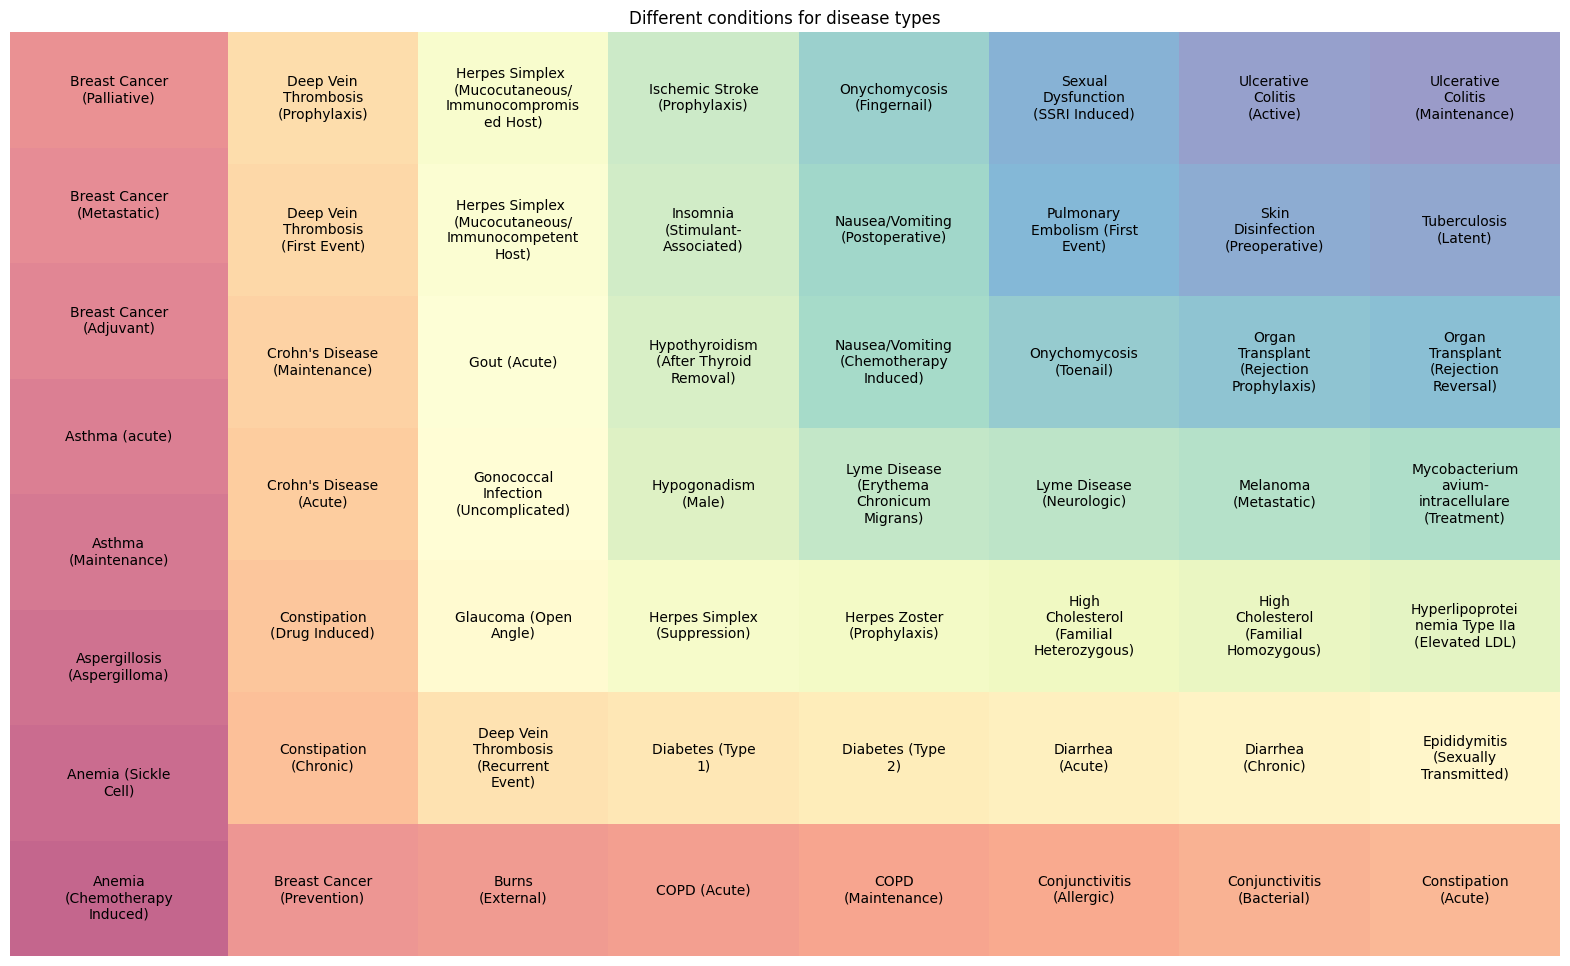

In [341]:

labels = []
sizes = []
for (disease, condition), count in disease_pairs.items():
    labels.append(f"{disease}\n({condition})")
    sizes.append(count)

colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

#figure to draw the treemap
plt.figure(figsize=(20, 12))
def wrap_labels(labels, width=10):
    return [textwrap.fill(label, width) for label in labels]

wrapped_labels = wrap_labels(labels, width=15)  # Adjust 'width' as needed

squarify.plot(sizes=sizes, label=wrapped_labels, color=colors, alpha=0.6)

plt.title("Different conditions for disease types")
plt.axis('off')
plt.show()

### No of Drugs for each disease:

In [342]:
df_sorted = df_data.dropna().sort_values(by='Number_of_Drugs', ascending=False)

In [343]:
disease_with_one_drug = len(df_sorted[df_sorted['Number_of_Drugs']==1])

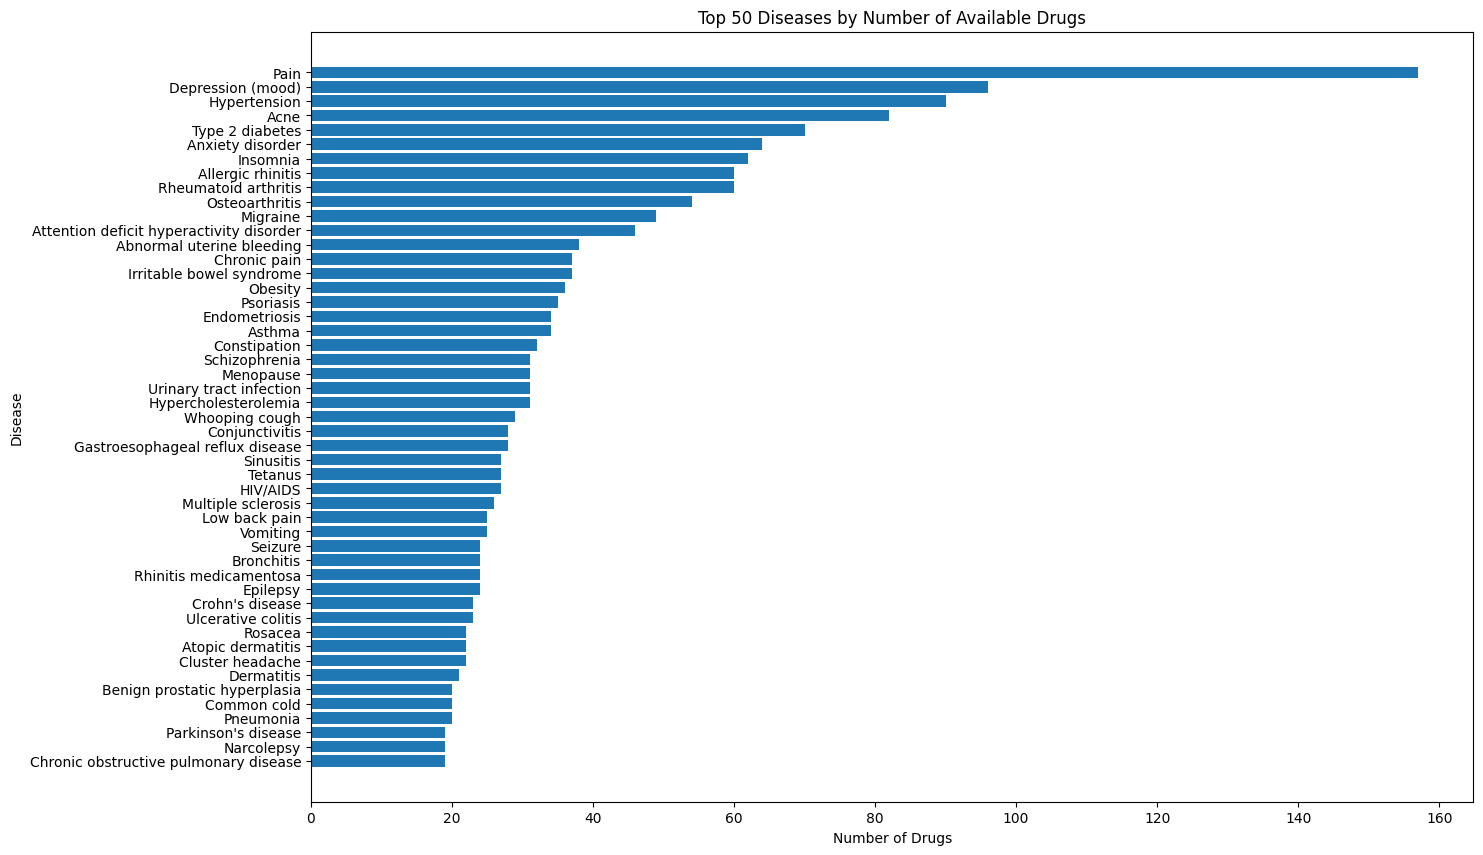

In [344]:

top_50 = df_sorted.head(50)
# Plotting
plt.figure(figsize=(15, 10))
plt.barh(top_50['Disease'], top_50['Number_of_Drugs'])
plt.xlabel('Number of Drugs')
plt.ylabel('Disease')
plt.title('Top 50 Diseases by Number of Available Drugs')
plt.gca().invert_yaxis()  # Invert y-axis to have the disease with the highest count on top
plt.show()

### Top 10 Most Prescribed Drugs

In [345]:
top_n = 10
df_data['DrugName_string'] = df_data['DrugName_list'].apply(lambda x: ', '.join(x))
top_drugs = df_data.groupby('DrugName_string').size().nlargest(top_n)

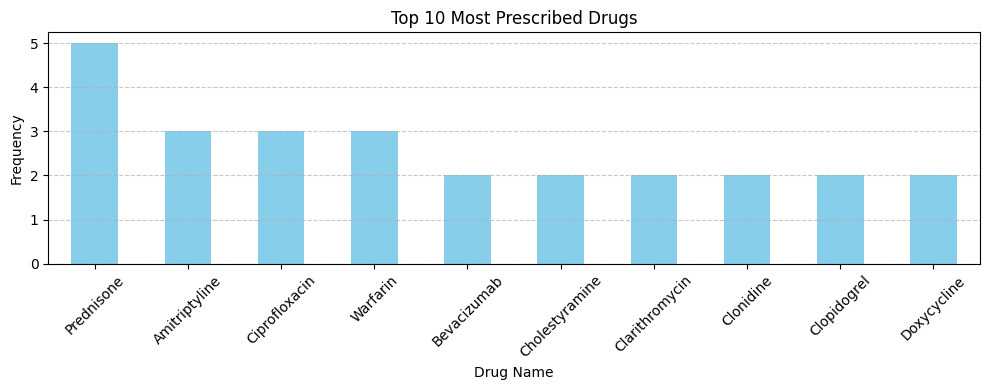

In [346]:
plt.figure(figsize=(10, 4))
top_drugs.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Most Prescribed Drugs')
plt.xlabel('Drug Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Diseases and it's condition that top 10 drugs are prescribed for

In [347]:
drug_names = top_drugs.index.tolist()
filtered_df = df_data[df_data['DrugName_list'].apply(lambda x: any(drug in x for drug in drug_names))]
all_diseases_in_top10_drugs = ' '.join(filtered_df['Disease'].dropna())

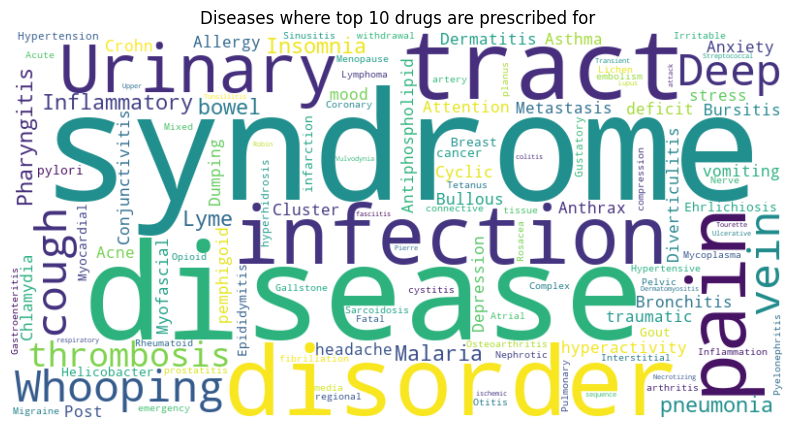

In [348]:
# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_diseases_in_top10_drugs)

# word cloud plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Diseases where top 10 drugs are prescribed for')
plt.axis('off')
plt.show()

### Analysis on symptoms

In [353]:
max_size = df_data['Symptoms_Length'].max()

In [364]:
disease_without_symptoms = len(df_data[df_data['Symptoms'].isna() == True]['Prescribed_for'].unique())

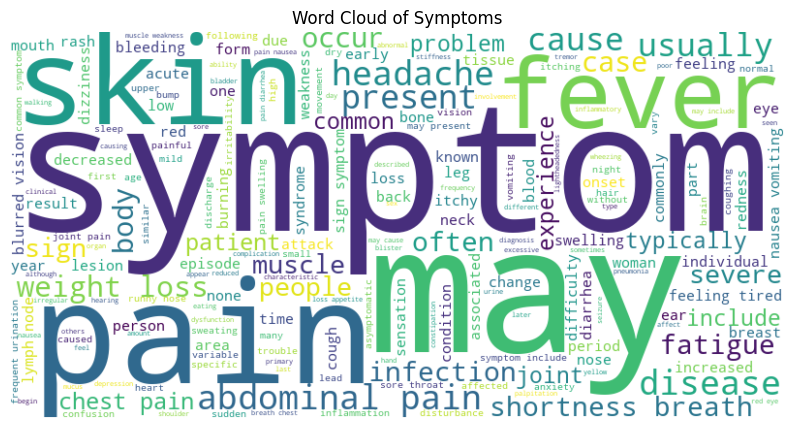

In [349]:
# Word cloud generation
all_preprocessed_symptoms = ' '.join(df_data['Preprocessed_Symptoms'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_preprocessed_symptoms)

# Word cloud Plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Symptoms')
plt.axis('off')
plt.show()


### Co-ocurences of Symptoms - Which Symptoms come together

In [350]:
# Tokenizing the symptoms
symptoms_tokenized = df_data['Symptoms'].dropna().str.split(', ')

# Counting the co-occurrences of symptoms
symptom_pairs = Counter()
for symptoms in symptoms_tokenized:
  symptom_pairs.update(combinations(symptoms,3))


# Most common symptoms occuring together
print("Symptoms that are occuring together are : \n")
symptom_cooccuring={}
for pair, count in symptom_pairs.most_common(30):
  symptom_cooccuring[pair]=count
  print(pair, "-", count)

Symptoms that are occuring together are : 

('Abdominal pain ', 'fever ', 'fatigue ') - 6
('Abdominal pain ', 'weight loss ', 'fatigue ') - 6
('Pain', 'swelling ', 'redness') - 5
('Pain', 'swelling ', 'enlarged veins in the affected limb') - 5
('Pain', 'redness', 'enlarged veins in the affected limb') - 5
('swelling ', 'redness', 'enlarged veins in the affected limb') - 5
('intense eye pain', 'nausea and vomiting ,a red eye', 'a headache tenderness around the eyes') - 5
('intense eye pain', 'nausea and vomiting ,a red eye', 'seeing rings around lights') - 5
('intense eye pain', 'nausea and vomiting ,a red eye', 'blurred vision') - 5
('intense eye pain', 'a headache tenderness around the eyes', 'seeing rings around lights') - 5
('intense eye pain', 'a headache tenderness around the eyes', 'blurred vision') - 5
('intense eye pain', 'seeing rings around lights', 'blurred vision') - 5
('nausea and vomiting ,a red eye', 'a headache tenderness around the eyes', 'seeing rings around lights') 

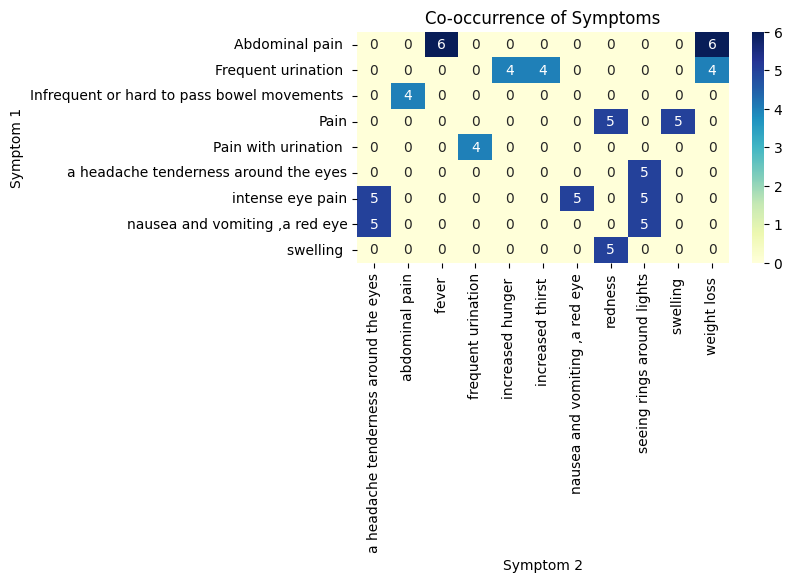

In [351]:
df = pd.DataFrame(symptom_cooccuring.items(), columns=['Symptom Pair', 'Count'])
df = df.groupby('Symptom Pair')['Count'].sum().reset_index()
df[['Symptom 1', 'Symptom 2', 'Symptom 3']] = pd.DataFrame(df['Symptom Pair'].tolist(), index=df.index)
pivot_table = df.pivot_table(index='Symptom 1', columns='Symptom 2', values='Count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Co-occurrence of Symptoms')
plt.xlabel('Symptom 2')
plt.ylabel('Symptom 1')
plt.show()

### Splitting the data


In [368]:
df_disease_table = df_data[['Disease','Preprocessed_Symptoms']]

In [371]:
df_disease_table_without_nan = df_disease_table.dropna()

In [ ]:
df_disease_table_without_nan.to_csv("../data/disease_with_symptoms.csv")

In [372]:
df_disease_with_condition_table = df_data[['Disease','Prescribed_for','DrugName_list']]

In [377]:
df_disease_with_condition_table.to_csv("../data/disease_with_condition.csv")